# Portfolio Optimization with constraints in atoti

In the previous notebook - "[Running Portfolio Optimization in atoti](https://github.com/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/portfolio-management/cvar-optimizer/main.ipynb)", we have demonstrated how a portfolio optimizer can be integrated into [atoti](https://www.atoti.io/). Using atoti, we can perform benchmarking against the initial portfolio.

In this notebook, we upped the game by having the possibility to optimize portfolio with a combination of the following constraints:
- Target returns
- Setting upper and/or lower weight limits on sectors
- Setting upper and/or lower weight limits on tickers

## What we can do...

Using the <img src="https://data.atoti.io/notebooks/banners/atoti-Logo-Icon-RGB.png" style="vertical-align: middle; width: 30px"/> [atoti community edition](https://docs.atoti.io/latest/eula.html), we used iPyWidget to put together an interactive form within the notebook for users to optimize the portfolio.  

__Now, we can perform these optimizations...:__

1. Optimize tickers by sector to find the optimal weights suggested by two different optimization algorithm - (1) minimum volatility and (2) maximum Sharpe.
  
<img src="img/00-sector_opt.gif" />  
  
2. Optimize tickers by portfolio using basic optimization, i.e. using historical pricing of tickers under the portfolio, the optimizer propose 2 sets of weights based on (1) minimum volatility and (2) maximum Sharpe.  
  
<img src="img/01-basic-optimization.gif" />  
  
3. Optimize with weight constraints either on sector (using "Optimize sector" button), individual ticker (using "Optimize tickers" button) or both (using "Optimize Portfolio" button). Choose to optimize with the objective of minimizing CVaR or achieving target returns.   
  
<img src="img/02-constraints.gif" />  
   
__Note:__ Sometimes, the objectives/constraints used may be infeasible. Adjust accordingly.  

Compare the downstream KPI against the benchmark, continue to tweak the portfolio for another iteration until you're satisfied with the final returns for the given risk appetite!

<img src="img/03-dashboard.gif" />  

<br/>   

> Note: All GIFs displayed within this notebook are based on atoti version 0.7.1.  

<br/>
  
You can do much more with [Atoti+](https://www.activeviam.com/atoti-technology/), the enterprise version of atoti. We could develop custom widgets that could be embedded into the dashboard for a complete experience! Reach out to [ActiveViam](https://www.activeviam.com/contact-us/) for more information.


<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=cvar_opt1" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

## Libraries used

Similar to the previous use case, we assume that we have received a portfolio with the initial weights for its tickers. 
Along with the portfolio, we have 3 years worth of data downloaded from [Yahoo Finance](https://finance.yahoo.com/) using [yfinance library](https://pypi.org/project/yfinance/).

We used [atoti](https://www.atoti.io/) to spin up a BI analytic platform, where all the data are stored in the in-memory cube.  
These data includes the optimized weights that will be returned by the portfolio optimizer - [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/index.html). 

In [1]:
# ! pip install yfinance ipywidgets PyPortfolioOpts

In [2]:
from importlib.metadata import version

import atoti as tt

This notebook is build using the following atoti version.

In [3]:
version(tt.__name__)

'0.7.1'

## 1. Data modeling for portfolio

### 1.1 Create session

Let's instantiate a session with persistent storage to save our dashboards.

In [4]:
session = tt.Session(user_content_storage="./content-atoti", port=10010)

### 1.2 Create tables

In this use case, we create the structures of our tables before loading the data.  

In [5]:
portfolio_tbl = session.create_table(
    name="Portfolios Allocation",
    types={
        "Portfolio": tt.STRING,
        "Tickers": tt.STRING,
        "Weights": tt.DOUBLE,
        "Iteration": tt.STRING,
        "Opt Method": tt.STRING,
    },
    default_values={"Iteration": "-", "Opt Method": "Base"},
    keys=["Portfolio", "Tickers", "Iteration", "Opt Method"],
)

In [6]:
price_tbl = session.create_table(
    name="Price",
    types={
        "Tickers": tt.STRING,
        "Price_Vector": tt.DOUBLE_ARRAY,
        "Daily_Returns_Vector": tt.DOUBLE_ARRAY,
        "Daily_ROR_Vector": tt.DOUBLE_ARRAY,
        "Monthly_ROR_Vector": tt.DOUBLE_ARRAY,
    },
    keys=["Tickers"],
)

In [7]:
dates_tbl = session.create_table(
    name="Historical Dates",
    types={
        "Historical Dates": tt.LOCAL_DATE,
        "Date Index": tt.INT,
        "Monthly Date Index": tt.INT,
    },
    keys=["Historical Dates"],
    default_values={"Date Index": -1, "Monthly Date Index": -1},
)

Alternatively, you could use functions such as [`atoti.read_csv`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.read_csv) or [`atoti.read_pandas`](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.read_pandas) to create and load data into table from a data source.  
For instance, we took a snapshot of the security description from wikipedia and load it into a reference table.

In [8]:
tickers_tbl = session.read_csv(
    "s3://data.atoti.io/notebooks/cvar2/data/constituents.csv",
    keys=["Tickers"],
)
tickers_tbl.head(3)

,Security,GICS Sector,GICS Sub-Industry
Tickers,,,
ARE,Alexandria Real Estate Equities,Real Estate,Office REITs
AME,Ametek,Industrials,Electrical Components & Equipment
BALL,Ball Corporation,Materials,Metal & Glass Containers


### 1.3 Join tables

We enrich the data from the _Portfolios Allocation_ table by joining to some reference table.  
atoti assume a join based on the common columns between the two table. Otherwise, we could explicitly perform the join by declaring the column mappings. Refer to [atoti documentation](https://docs.atoti.io/latest/index.html) for more examples on [join](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Join).

In [9]:
portfolio_tbl.join(tickers_tbl)
portfolio_tbl.join(price_tbl)
portfolio_tbl.join(dates_tbl)

### 1.4 Create cube  

Below shows how we built an in-memory data cube from the base store `Portfolios Allocation` table.  
In the [default creation mode](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_cube), atoti creates hierarchies from non-numerical and key columns, a mean and sum measure from numerical columns.

In [10]:
cube = session.create_cube(portfolio_tbl, "Portfolio optimization")

As we are dealing with historical data in this use case, we stored the historical values as arrays in the _Price_ table.  For each element in the array, we have a corresponding date in the _Historical Dates_ table. We will use the index columns in the _Historical Dates_ to perform the mapping later on.

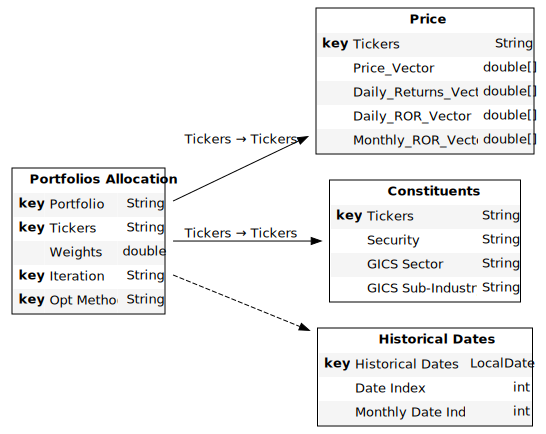

In [11]:
cube.schema

## 2. Data Loading

Once the table is created, we can call the table's loading functions to load data for the corresponding data type.  
In this case, we use `table.load_csv` to load csv data files into the tables.

In [12]:
portfolio_tbl.load_csv("s3://data.atoti.io/notebooks/cvar2/data/initial_portfolio.csv")
price_tbl.load_csv(
    "s3://data.atoti.io/notebooks/cvar2/data/historical_prices.csv",
    array_separator=",",
)
dates_tbl.load_csv("s3://data.atoti.io/notebooks/cvar2/data/historical_price_index.csv")

## 3. Manipulate hierarchies

### 3.1 Slicing

Since we look at the performance of each optimization method separately (i.e. we do not perform aggregation across optimization methods), we can set the hierarchy to [slicing](https://docs.atoti.io/latest/lib/atoti/atoti.hierarchy.html#atoti.Hierarchy.slicing) such that we view the initial portfolio - `Base` by default.

In [13]:
h = cube.hierarchies
h["Opt Method"].slicing = True

## 4. Create business metrics  

In the previous notebook - "[Running Portfolio Optimization in atoti](https://github.com/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/portfolio-management/cvar-optimizer/main.ipynb)", we have created the following business metrics for our benchmarking purpose:
- [VaR](https://www.investopedia.com/terms/v/var.asp)
- [CVaR](https://www.investopedia.com/terms/c/conditional_value_at_risk.asp), also known as expected shortfall
- [Sharpe Ratio](https://www.investopedia.com/terms/s/sharperatio.asp)
- [Error Tracking](https://www.investopedia.com/terms/t/trackingerror.asp)

In this notebook, we have added in some additional metrics:
- [Expected returns](https://www.investopedia.com/terms/e/expectedreturn.asp) and the weighted expected returns
- [Volatility](https://www.investopedia.com/terms/v/volatility.asp)
- [Information ratio](https://www.investopedia.com/terms/i/informationratio.asp)

We will be working a lot with `cube.levels` and `cube.measures`, so let's alias them to make coding easier.

In [14]:
l, m = cube.levels, cube.measures

### 4.1 Working with array to compute VaR and CVaR

atoti has a series of functions that enable us to [work with arrays](https://docs.atoti.io/latest/lib/atoti/atoti.array.html).  

Since our _Price_ table is a reference table, we will have to create the measures for our arrays.  
Let's use the [`atoti.agg.single_value`](https://docs.atoti.io/latest/lib/atoti/atoti.agg.single_value.html) to obtain the array for each of the tickers in the portfolio.

In [15]:
m["Daily_Returns_Vector"] = tt.agg.single_value(price_tbl["Daily_Returns_Vector"])
m["Daily_ROR_Vector"] = tt.agg.single_value(price_tbl["Daily_ROR_Vector"])
m["Monthly_ROR_Vector"] = tt.agg.single_value(price_tbl["Monthly_ROR_Vector"])
m["Price_Vector"] = tt.agg.single_value(price_tbl["Price_Vector"])

In [16]:
session.visualize("Historical data by security")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.1 Aggregating weighted array

We apply the weights of each ticker on their daily returns. Note that we are aggregating from the table and _not_ the measures.

In [17]:
m["Simulated Portfolio Returns Vector"] = tt.agg.sum(
    portfolio_tbl["Weights"] * price_tbl["Daily_ROR_Vector"]
)

m["Unweighted RoR Vector"] = tt.agg.sum(price_tbl["Daily_ROR_Vector"])

By performing a summation on the vector above the _Tickers_ level, we obtained an array containing the daily returns of the portfolio.

In [18]:
session.visualize("Pricing simulation")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.2 Computing VaR with parameter simulation

We could create a measure for `Confidence Level` at 95% simply by:
```
m["Confidence Level"] = 0.95
```

However, we used the function [`cube.create_parameter_simulation`](https://docs.atoti.io/latest/lib/atoti/atoti.cube.html#atoti.Cube.create_parameter_simulation) to create this measure instead.

In [19]:
confidence_levels = cube.create_parameter_simulation(
    "Confidence Level",
    measures={"Confidence Level": 0.95},
    base_scenario_name="95%",
)

This will allow us to perform simulation on other confidence levels and compare their downstream business metrics accordingly. 

In [20]:
confidence_levels += ("90%", 0.90)
confidence_levels += ("98%", 0.98)

Now, we can use [`atoti.array.quantile`](https://docs.atoti.io/latest/lib/atoti/atoti.array.quantile.html) to obtain the greatest loss at 95% confidence level.  
The below [atoti quantile function](https://docs.atoti.io/latest/lib/atoti/atoti.array.quantile.html) used the default `PERCENTILE.INC` mode with interpolation set to `lower`. Check out atoti's documentation to see how you can achieve the standard quantile calculations through different combination of modes and interpolations.

In [21]:
m["VaR"] = tt.array.quantile(
    m["Simulated Portfolio Returns Vector"],
    (1 - m["Confidence Level"]),
    interpolation="lower",
)

# unweighted
m["Ticker VaR"] = tt.array.quantile(
    # m["Daily_ROR_Vector"],
    m["Unweighted RoR Vector"],
    (1 - m["Confidence Level"]),
    interpolation="lower",
)

m["VaR"].formatter = "DOUBLE[#,##0.000%]"
m["Ticker VaR"].formatter = "DOUBLE[#,##0.000%]"

This demonstrates how atoti easily achieve non-linear aggregation.

In [22]:
session.visualize("VaR at different confidence level")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.3 Computing CVaR

CVaR, also known as the expected shortfall, is the weighted average of the losses beyond the VaR cutoff point.  
Therefore, let's get the position of the VaR in the array and compute the CVaR.

In [23]:
m["Number of Tail Exposures"] = tt.math.floor(
    (1 - m["Confidence Level"]) * tt.array.len(m["Simulated Portfolio Returns Vector"])
)

m["CVaR"] = tt.array.mean(
    tt.array.n_lowest(
        m["Simulated Portfolio Returns Vector"], m["Number of Tail Exposures"]
    )
)

# unweighted
m["Ticker CVaR"] = tt.array.mean(
    # tt.array.n_lowest(m["Daily_ROR_Vector"], m["Number of Tail Exposures"])
    tt.array.n_lowest(m["Unweighted RoR Vector"], m["Number of Tail Exposures"])
)

m["CVaR"].formatter = "DOUBLE[#,##0.000%]"
m["Ticker CVaR"].formatter = "DOUBLE[#,##0.000%]"

In [24]:
session.visualize("Portfolio 1 - VaR and CVaR at ticker level")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.4 Expanding arrays

To query the tickers' values at historical dates level, we need to expand the arrays.  
We can simply use the `Date Index` and `Monthly Date Index` to return the value at the daily level or monthly level.

In [25]:
# creating measures for the indices
m["Date Index"] = tt.agg.single_value(dates_tbl["Date Index"])

mthly_idx = tt.agg.single_value(dates_tbl["Monthly Date Index"])
m["Monthly Date Index"] = tt.where(mthly_idx != -1, mthly_idx)

# Daily values
m["Daily Price"] = m["Price_Vector"][m["Date Index"]]
m["Daily Price"].formatter = "DOUBLE[#,###.00000]"

m["Daily ROR"] = m["Daily_ROR_Vector"][m["Date Index"]]
m["Daily ROR"].formatter = "DOUBLE[#,##0.000%]"

# non-weighted
m["Daily Returns"] = m["Daily_Returns_Vector"][m["Date Index"]]
m["Daily Returns"].formatter = "DOUBLE[#,###.00000]"

# weighted
m["Daily Portfolio Returns"] = m["Simulated Portfolio Returns Vector"][m["Date Index"]]
m["Daily Portfolio Returns"].formatter = "DOUBLE[#,##0.000%]"

# monthly values
m["Monthly ROR"] = m["Monthly_ROR_Vector"][m["Monthly Date Index"]]
m["Monthly ROR"].formatter = "DOUBLE[#,##0.000%]"

In [26]:
session.visualize("Portfolio 1 - Monthly ROR")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.5 Performing cumulative returns

In [27]:
m["Since Inception ROR"] = (
    tt.agg.prod(
        (m["Daily Portfolio Returns"] + 1),
        scope=tt.CumulativeScope(level=l["Historical Dates"]),
    )
    - 1
)
m["Since Inception ROR"].formatter = "DOUBLE[#,##0.000%]"

In [28]:
session.visualize("Portfolio 1 - Returns since inception")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.6 Computing Expected returns and Weighted expected returns

One of the optimization algorithms that we will implement involves setting a target return.  
Therefore, it is important for us to synchronize [computation formula](https://pyportfolioopt.readthedocs.io/en/latest/_modules/pypfopt/expected_returns.html?highlight=mean_historical_return#) of expected returns with the optimizer.  

In our use case, we will be using the [`mean historical return`](https://pyportfolioopt.readthedocs.io/en/latest/ExpectedReturns.html#pypfopt.expected_returns.mean_historical_return) to calculate the annualized mean historical returns from the daily asset price.  
We assume there's 252 business days in a year.

In [29]:
frequency = 252

# we exclude the first date as this value is dropped in optimizer
m["Expected returns"] = tt.agg.sum(
    tt.array.prod(m["Daily_ROR_Vector"][1:] + 1)
    ** (frequency / tt.array.len(m["Daily_ROR_Vector"]))
    - 1,
    scope=tt.OriginScope(l["Tickers"]),
)
m["Expected returns"].formatter = "DOUBLE[#,##0.000%]"

Simply multiply the `Expected returns` by the weight of each ticker and sum them up to obtain the `Weighted expected returns`.

In [30]:
m["Weighted expected returns"] = tt.agg.sum(
    m["Expected returns"] * m["Weights.SUM"],
    scope=tt.OriginScope(l["Tickers"]),
)

m["Weights.SUM"].formatter = "DOUBLE[#,##0.00000]"
m["Weighted expected returns"].formatter = "DOUBLE[#,##0.000%]"

#### 4.1.7 Computing Volatility

[Volatility](https://www.investopedia.com/terms/v/volatility.asp) is the rate of price change for a ticker over a period of time. Higher ticker price volatility implies higher risk.  
In our use case, we make use of the standard deviations of returns to measure volatility. Standard deviation is the square root of variance. We can easily compute this using the [atoti array functions](https://docs.atoti.io/latest/lib/atoti/atoti.array.html).

In [31]:
_volatility = tt.agg.sqrt(tt.array.var(m["Daily_ROR_Vector"]) * frequency)

# ignoring correlations between ticker
m["Volatility"] = tt.agg.sum_product(
    _volatility, m["Weights.SUM"], scope=tt.OriginScope(l["Tickers"])
)
m["Volatility"].formatter = "DOUBLE[#,##0.000%]"

# unweighted volatility
m["Ticker volatility"] = tt.agg.sum(_volatility, scope=tt.OriginScope(l["Tickers"]))
m["Ticker volatility"].formatter = "DOUBLE[#,##0.000%]"

### 4.2 Computing Sharpe Ratio

The [Sharpe ratio](https://www.investopedia.com/ask/answers/010815/what-good-sharpe-ratio.asp) compares the return of an investment with its risk, showing how much excess return is received for the additional risk.  
The formula for Sharpe ration is as follows: 

$$Sharpe\ Ratio = {{R_{p} - R_{f}}\over {\sigma_{p}}}$$

Where  
$$R_{p} = Return\ of\ portfolio$$
$$R_{f} = Risk-free\ rate$$
$${\sigma_{p}} = Standard\ deviation\ of\ the\ portfolio's\ excess\ return\ (Volatility) $$

The greater a portfolio's Sharpe ratio, the better its risk-adjusted performance. Generally, we gauge the performance as follows:
- Good: 1 < SR < 2
- Very good: 2 < SR < 3
- Execllent: 3 < SR

Let's start by assuming the risk-free rate is 0%.

In [32]:
# https://www.mlq.ai/python-for-finance-portfolio-optimization/

m["Mean daily return"] = tt.array.mean(m["Simulated Portfolio Returns Vector"])
m["Mean daily return"].formatter = "DOUBLE[#,###.00000]"

m["Portfolio std"] = tt.array.std(m["Simulated Portfolio Returns Vector"])
m["Portfolio std"].formatter = "DOUBLE[#,###.00000]"

m["Sharpe ratio"] = m["Mean daily return"] / m["Portfolio std"]
m["Sharpe ratio"].formatter = "DOUBLE[#,##0.0000]"

# unweighted
# m_ticker_daily_return = tt.array.mean(m["Daily_ROR_Vector"])
# m_ticker_std = tt.array.std(m["Daily_ROR_Vector"])
m_ticker_daily_return = tt.array.mean(m["Unweighted RoR Vector"])
m_ticker_std = tt.array.std(m["Unweighted RoR Vector"])
m["Ticker Sharpe ratio"] = m_ticker_daily_return / m_ticker_std
m["Ticker Sharpe ratio"].formatter = "DOUBLE[#,##0.0000]"

In [33]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 4.3 Deriving Error Tracking using Factless Hierarchy

In the previous use case, we used the initial portfolio as the benchmark. 

$$Tracking\ Error = {\sigma(P-B)}$$

Where  
P = Daily Portfolio returns  
B = Daily Portfolio returns of benchmark  

Note: Portfolio with `Opt Method` equals to `Base` is the benchmark.

In this use case, we explore the possibility of benchmarking different iterations of the optimization. To do this, we will create the `Benchmark Methods` column from `portfolio_tbl["Opt Method"]`. The following function creates a factless hierarchy where it doesn't contain any measures.

In [34]:
cube.create_parameter_hierarchy_from_column(
    "Benchmark Methods", portfolio_tbl["Opt Method"]
)

To be able to compare the `Benchmark Methods` against hte `Opt Method`, we also map some of their measures to the corresponding `Benchmark Methods` using the [`atoti.at` function](https://docs.atoti.io/latest/lib/atoti/atoti.function.at.html#atoti.at).

In [35]:
m["Benchmark Returns Vector"] = tt.at(
    m["Simulated Portfolio Returns Vector"],
    l["Opt Method"] == l["Benchmark Methods"],
)

In [36]:
m["PnL vs Benchmark"] = (
    m["Simulated Portfolio Returns Vector"] - m["Benchmark Returns Vector"]
)
m["PnL vs Benchmark"].formatter = "DOUBLE[#,###.00000]"

The beauty of multidimensional analytics is that we can easily benchmark the optimization iterations against each other:  

<img src="https://data.atoti.io/notebooks/cvar2/img/error-tracking-benchmark.png" />

Since `Benchmark Methods` is a factless hierarchy mirroring `Opt Method`, it will contain the members of all the `Opt Method` regardless of the portfolio.  
Therefore, when we want to make sensible comparison between iterations of the same portfolio, we exclude those where `Benchmark Returns Vector` is not available such that members belonging to other portfolios will not be displayed.

In [37]:
m["Error tracking"] = tt.where(
    ~m["Benchmark Returns Vector"].isnull(),
    tt.array.std(m["PnL vs Benchmark"], mode="population"),
)
m["Error tracking"].formatter = "DOUBLE[#,###.00000]"

### 4.4 Deriving Information Ratio using Factless hierarchy

The [information ratio (IR)](https://www.investopedia.com/terms/i/informationratio.asp) is a measurement of portfolio returns beyond the returns of a benchmark, usually an index, compared to the volatility of those returns.  
It shows the portfolio manager's ability to generate excess returns relative to a benchmark.  

Similar to the `Error tracking`, we can use each iteration as a benchmark against the other iteration.

In [38]:
m["Weighted Benchmark Expected Returns"] = tt.at(
    m["Weighted expected returns"],
    (l["Opt Method"] == l["Benchmark Methods"]),
)

In [39]:
m["Information ratio"] = tt.where(
    ~m["Weighted Benchmark Expected Returns"].isnull(),
    (m["Weighted expected returns"] - m["Weighted Benchmark Expected Returns"])
    / m["Error tracking"],
)
m["Information ratio"].formatter = "DOUBLE[#,###.00000]"

## 5. Using simulation to store sector/ticker limits

We will see later on, with the use of ipywidget, we will be able to set upper and lower weight limits for each sector and each ticker.  
Instead of creating a table to store these information, we could use [parameter simulation](https://docs.atoti.io/latest/getting_started/tutorial/tutorial.html#Parameter-simulations) to store the minimum and maximum weight as shown below:

In [40]:
sector_weight_simulation = cube.create_parameter_simulation(
    "Weight simulation",
    measures={
        "Max sector weight": None,
        "Min sector weight": None,
        "Max ticker weight": None,
        "Min ticker weight": None,
        "Target returns": None,
    },
    levels=[
        l["Portfolio"],
        l["Opt Method"],
        l["GICS Sector"],
        l["Tickers"],
    ],
)

In [41]:
weight_limit = (
    m["Max ticker weight"]
    + m["Min ticker weight"]
    + m["Max sector weight"]
    + m["Min sector weight"]
)

m["Objective"] = tt.where(
    {
        ~m["Target returns"].isnull(): "Target returns",
        ~weight_limit.isnull(): "Minimize CVaR",
    }
)

In the script [query_utils.py](utils/query_utils.py), look at the `load_limits` function to see how we could load the limits into atoti.

## 6. Integrate portfolio optimization 

atoti is able to integrate with your own optimizer as shown below.  

<img src="https://data.atoti.io/notebooks/cvar-optimisation/img/system_design3.png" width="75%" />
  
  
Below is a simple demonstration of how the integration between atoti, ipywidgets and pyPortfolioOpt.

In [42]:
import time

import ipywidgets as wid
from utils import optimizer_utils as opt_utils
from utils import query_utils
from utils import widget_utils as widgets

In [43]:
optimizer = opt_utils.Optimizer()
query = query_utils.Query(session)

In [44]:
def upload_sector_weight(df, _sector, _opt_mtd):
    new_iteration = time.strftime("%Y%m%d_%X")

    df["Portfolio"] = _sector
    df["Iteration"] = new_iteration
    df["Opt Method"] = f"{_opt_mtd}_{new_iteration}"

    portfolio_tbl.load_pandas(df)


def optimize_sector(b):
    print(sector_dropdown.value)
    sector = sector_dropdown.value

    historical_pricing = query.get_historical_price_by_sector(sector)

    weights_min_vol = optimizer.basic_min_volatility(historical_pricing)
    upload_sector_weight(weights_min_vol, sector, "Min volatility")

    weights_max_sharpe = optimizer.basic_max_sharpe(historical_pricing)
    upload_sector_weight(weights_max_sharpe, sector, "Max Sharpe")

    msg.value = (
        f'<h4 style="color:green;">Optimization completed for {sector} sector.</h4>'
    )

In [45]:
sector_list = query.get_distinct_sectors()

sector_dropdown = wid.Dropdown(
    options=sector_list,
    value=None,
    description="Sector:",
    disabled=False,
)

sector_button = wid.Button(
    description="Optimize sector",
    button_style="info",
    tooltip="Optimize tickers under sector",
    icon="gear",
)

msg = wid.HTML(value=None)

sector_button.on_click(optimize_sector)

### 7.1 Optimizing within a sector

In [46]:
display(wid.VBox([wid.HBox([sector_dropdown, sector_button]), msg]))

We will create a new portfolio named after the sector.  
__Check out the following dashboard to see which tickers the optimizer suggests for the selected sector.__

In [47]:
session.link(path="/#/dashboard/768")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### 7.2 Optimizing a portfolio

Below is a more complex example where we can further optimize each portfolio by one of the following:
- Basic optimization: Ignoring the weights, we run the historical pricing for the tickers from the selected portfolio/iteration/opt mtd through two algorithms:
    - Min Volatility
    - Max Sharpe
- Optimize sector: Only the min. and max. weights for the sectors are taken into consideration for the optimization. The tickers are allocated weights by the algorithm based on the selected objective-either minimized CVaR or target returns. 
- Optimize tickers: Only the min. and max. weights for the tickers are taken into consideration for the optimization, depending on the selected objective.
- Optimize portfolio: The min. and max. weights for both the sectors and tickers are taken into consideration for the optimization with regards to the selected objective.

__Details of the implementation__
- To tweak the optimization algorithm, refer to the script [optimizer_utils.py](utils\optimizer_utils.py).
- To modify the ipywidgets, refer to the script [widget_utils.py](utils\widget_utils.py)
- To modify the atoti query for the ipywidgets interaction and portfolio optimization, refer to the script [query_utils.py](utils\query_utils.py)

__Launch the following dashboard to see the performance of the optimized portfolio.__

In [48]:
session.link(path="/#/dashboard/91b")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

In [49]:
def get_display():
    wid = widgets.Widgets(query)
    wid.display()

In [50]:
get_display()

__Note:__ Limits for tickers under sector will be set to 0 in the backend if the sector's max. weight is set to 0.

## Conclusion

We can easily implement an upload function that allow users to upload their own portfolio (refer to the previous use case - "[Running Portfolio Optimization in atoti](https://github.com/atoti/notebooks/blob/main/notebooks/01-use-cases/finance/portfolio-management/cvar-optimizer/main.ipynb)"). Similarly, we could extend further to allow users to add new tickers to their portfolios. The combination is up to your imagination.  

Instead of toggling between Jupyter notebook and atoti BI Web application, why not have a custom widget integrated into the dashboard and tweak your portfolio as you see the impact in a matter of seconds? __Don't have Atoti+ license yet? Reach out to [ActiveViam](https://www.activeviam.com/contact-us/) for a demonstration to see how we integrate the portfolio optimization program into the BI analytics platform!__

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=cvar_opt1" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>